In [1]:
import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate()
#import Pkg; Pkg.activate(joinpath(@__DIR__,"..")); Pkg.instantiate()

  Activating environment at `~/.julia/dev/iLQGameSolver/examples/Project.toml`


In [3]:
using Revise # For rapid prototyping

using LinearAlgebra
using Plots
using SparseArrays
using ForwardDiff
using Random
using Test
using StaticArrays
using iLQGameSolver

┌ Info: Precompiling iLQGameSolver [894a8279-595f-4c20-8f0c-63b9232f715b]
└ @ Base loading.jl:1342


### Differential Drive continous kinematics



\begin{split}
\dot x &= v\cos(\theta)\\
\dot y &= v\sin(\theta)\\
\dot \theta &= \omega\\
\end{split}

Where $[\dot x, \dot y, \dot \theta]$ are the state, and $[v, \omega]$ are the control inputs.

In [4]:
# Turtlebot Burger radius ≈ 0.2 m
R = 0.2
# Setup the problem
dt = 0.1                    # Step size [s]
H = 30.0                    # Horizon [s]
k_steps = Int(H/dt)         # Number of steps (knot points)

# Initial and final states
# x₁, y₁, θ₁     

# x₀= [5.0; 0.0; pi/2; 0.0; 0.0; 5.0; 0.0; 0.0]        # Initial state
# xgoal = [5.0; 10.0; pi/2; 0.0; 10.0; 5.0; 0.0; 0.0]; # Final state

In [5]:
# # Define cost matrices 

Q1 = sparse(zeros(6,6))     # State cost for agent 1
Q1[1:3,1:3] = 5.0*I(3)
Qn1 = Q1                    # Terminal cost for agent 1

Q2 = sparse(zeros(6,6))     # State cost for agent 2
Q2[4:6,4:6] = 1.0*I(3)
Qn2 = Q2                    # Terminal cost for agent 2

R11 = 1.0*I(2)              # Control cost for player 1
R22 = 1.0*I(2)              # Contorl cost for player 2
R12 = sparse(zeros(2,2))    # Control cost for player 1 associated with player 2's controls
R21 = sparse(zeros(2,2))    # Control cost for player 2 associated with player 1's controls

dmax = 1.0                  # Distance that both agents should keep between each other [m]
ρ = 100.0                   # Penalty factor for violating the distance constraint

# Input constraints
x₀    = [5.0; 0.0 ; pi/2; 0.0 ; 5.0; 0.0]        # Initial state
xgoal = [5.0; 10.0; pi/2; 10.0; 5.0; 0.0]; # Final state
umax = [2.0, 2.0, 2.0, 2.0]            
umin = [-1.0, -1.0, -1.0, -1.0]

u1goal = [0.0, 0.0]
u2goal = [0.0, 0.0];

In [6]:
# Define cost matrices 

# Q1 = sparse(zeros(8,8))     # State cost for agent 1
# Q1[1:4,1:4] = 1.0*I(4); Q1[3,3] = 4.0; Q1[4,4] = 6.0
# Qn1 = 10*Q1                    # Terminal cost for agent 1

# Q2 = sparse(zeros(8,8))     # State cost for agent 2
# Q2[5:8,5:8] = 1.0*I(4); Q2[7,7] = 4.0; Q2[8,8] = 5.0
# Qn2 = 10*Q2                    # Terminal cost for agent 2

# R11 = 6.0*I(2)              # Control cost for player 1
# R22 = 6.0*I(2)              # Contorl cost for player 2
# R12 = sparse(zeros(2,2))    # Control cost for player 1 associated with player 2's controls
# R21 = sparse(zeros(2,2))    # Control cost for player 2 associated with player 1's controls

# dmax = 4*R                  # Distance that both agents should keep between each other [m]
# ρ = 500.0                   # Penalty factor for violating the distance constraint

# x₀= [2.0; 0.0; pi/2; 0.0; 0.0; 2.0; 0.0; 0.0]        # Initial state
# xgoal = [2.0; 4.0; pi/2; 0.0; 4.0; 2.0; 0.0; 0.0]; # Final state
# # Input constraints
# umax = [0.1, 0.6, 0.1, 0.6]            
# umin = [-1.0,-0.6, -1.0, -0.6]

# u1goal = [0.0, 0.0]
# u2goal = [0.0, 0.0];

In [7]:
xₜ, uₜ = iLQGameSolver.solveILQGame(iLQGameSolver.diff_drive_3D, iLQGameSolver.costDiffDrive, 
                                    x₀, xgoal, u1goal, u2goal, Q1, Q2, Qn1, Qn2, R11, R12, R21, 
                                    R22, umin, umax, dmax, ρ, dt, H)

@show uₜ[1,1]*cos(rad2deg(xₜ[1,3]))

uₜ[1, 1] * cos(rad2deg(xₜ[1, 3])) = -0.8961472322583404


-0.8961472322583404

┌ Info: Saved animation to /home/ahmed/.julia/dev/iLQGameSolver/examples/assets/diff_drive_control.gif
└ @ Plots /home/ahmed/.julia/packages/Plots/Pn7Zn/src/animation.jl:149


Plots.AnimatedGif("/home/ahmed/.julia/dev/iLQGameSolver/examples/assets/diff_drive_control.gif")
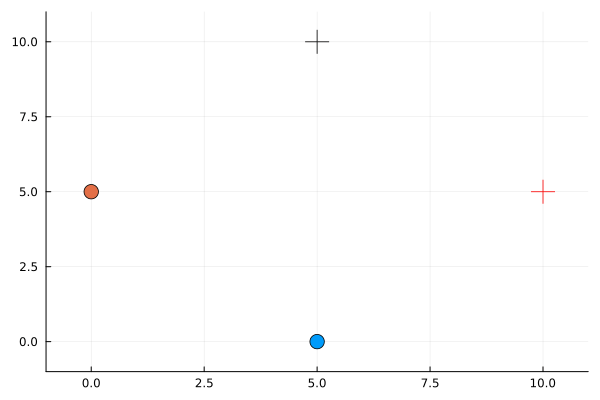

In [8]:
# Animation of the solution. GIF is saved in the assets folder.

anim = @animate for t in 1:k_steps
    scatter([xₜ[t, :][1]], [xₜ[t, :][2]], m = (:circle, 8),
    xlims = (-1, 11), 
    ylims = (-1, 11), 
    legend = false)
    scatter!([xₜ[t, :][4]], [xₜ[t, :][5]], m = (:circle, 8))
    plot!([xgoal[1]], [xgoal[2]], m = (:cross, 12, :black))
    plot!([xgoal[4]], [xgoal[5]], m = (:cross, 12, :red))
end every 1;
gif(anim, "assets/diff_drive_control.gif")

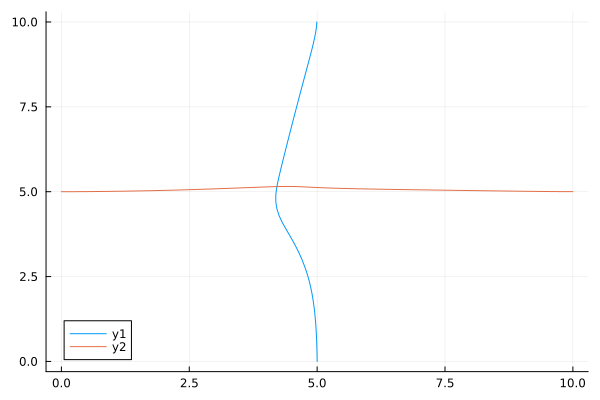

In [9]:
plot(xₜ[:, 1], xₜ[:, 2])
plot!(xₜ[:, 4], xₜ[:, 5])
